In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow as tf
from scipy import ndimage
import random
from tensorflow import keras
from tensorflow.keras import layers

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
tf.random.set_seed(1) # For reproducibility

In [3]:
# For brainLoss

X_train_brainLoss = pickle.load(open('X_train_brainLoss.pickle', 'rb'))
X_test_brainLoss = pickle.load(open('X_test_brainLoss.pickle', 'rb'))
y_train_brainLoss = pickle.load(open('y_train_brainLoss.pickle', 'rb'))
y_test_brainLoss = pickle.load(open('y_test_brainLoss.pickle', 'rb'))

print(f"X train shape: {X_train_brainLoss.shape}\nX test shape: {X_test_brainLoss.shape}")

X train shape: (918, 128, 128, 64)
X test shape: (393, 128, 128, 64)


In [4]:
@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def test_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [5]:
# brainLoss dataloaders (manage memory usage)
train_loader_brainLoss = tf.data.Dataset.from_tensor_slices((X_train_brainLoss, y_train_brainLoss))
test_loader_brainLoss = tf.data.Dataset.from_tensor_slices((X_test_brainLoss, y_test_brainLoss))

2022-04-09 10:17:52.917258: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-09 10:17:54.091826: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14592 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


In [6]:
batch_size = 24

# Augment the on the fly during training.
train_dataset_brainLoss = (
    train_loader_brainLoss.shuffle(len(X_train_brainLoss))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
test_dataset_brainLoss = (
    test_loader_brainLoss.shuffle(len(X_test_brainLoss))
    .map(test_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

In [7]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""    
    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=8, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=16, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=32, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 126, 126, 62, 8)   224       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 63, 63, 31, 8)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 31, 8)    32        
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 61, 61, 29, 16)    3472      
                                                             

In [8]:
initial_learning_rate = 0.00001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_brainLoss_class32_1.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

In [9]:
epochs = 30
model.fit(
    train_dataset_brainLoss,
    validation_data=test_dataset_brainLoss,
    epochs=epochs,
    shuffle=True,
    verbose=1,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/30


2022-04-09 10:18:21.024960: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2022-04-09 10:18:21.925294: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-09 10:18:21.925884: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-09 10:18:21.925900: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-04-09 10:18:21.926510: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-09 10:18:21.926560: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


39/39 [==============================] - 145s 4s/step - loss: 0.6433 - acc: 0.6776 - val_loss: 0.6773 - val_acc: 0.6310
Epoch 2/30
39/39 [==============================] - 144s 4s/step - loss: 0.5808 - acc: 0.8769 - val_loss: 0.6644 - val_acc: 0.6310
Epoch 3/30
39/39 [==============================] - 141s 4s/step - loss: 0.5179 - acc: 0.9641 - val_loss: 0.6523 - val_acc: 0.6310
Epoch 4/30
39/39 [==============================] - 144s 4s/step - loss: 0.4666 - acc: 0.9804 - val_loss: 0.6310 - val_acc: 0.6310
Epoch 5/30
39/39 [==============================] - 144s 4s/step - loss: 0.4320 - acc: 0.9847 - val_loss: 0.6057 - val_acc: 0.6438
Epoch 6/30
39/39 [==============================] - 143s 4s/step - loss: 0.3865 - acc: 0.9815 - val_loss: 0.5769 - val_acc: 0.9898
Epoch 7/30
39/39 [==============================] - 142s 4s/step - loss: 0.3585 - acc: 0.9793 - val_loss: 0.5436 - val_acc: 0.9822
Epoch 8/30
39/39 [==============================] - 142s 4s/step - loss: 0.3338 - acc: 0.9782 

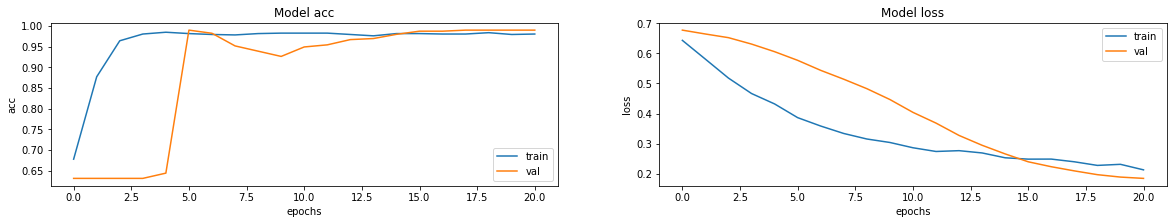

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

### Predictions

In [4]:
# Load saved model & weights
model = keras.models.load_model('3d_brainLoss_class32_1.h5')
model.load_weights("3d_brainLoss_class32_1.h5")

2022-04-10 15:26:43.856115: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-10 15:26:44.453248: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30942 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


In [5]:
model.predict(np.expand_dims(X_test_brainLoss[0], axis=0))[0]

2022-04-10 15:26:53.346051: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2022-04-10 15:26:53.832123: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-10 15:26:53.832542: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-10 15:26:53.832553: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-04-10 15:26:53.832877: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-10 15:26:53.832917: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


array([0.10984811], dtype=float32)

In [6]:
y_preds_brainLoss = []
for i in range(len(X_test_brainLoss)):
    if model.predict(np.expand_dims(X_test_brainLoss[i],axis=0))[0] < 0.5:
        y_preds_brainLoss.append(0)
    else:
        y_preds_brainLoss.append(1)

In [7]:
#confusion_matrix[y_test_brainLoss, y_preds_brainLoss]
tp = 0
tn = 0
fp = 0
fn = 0
for i in range(len(y_test_brainLoss)):
    if y_preds_brainLoss[i] == 0 and y_test_brainLoss[i] == 0:
        tp = tp+1
    elif y_preds_brainLoss[i] == 1 and y_test_brainLoss[i] == 1:
        tn = tn+1
    elif y_preds_brainLoss[i] == 0 and y_test_brainLoss[i] == 1:
        fp = fp+1
    elif y_preds_brainLoss[i] == 1 and y_test_brainLoss[i] == 0:
        fn = fn+1

In [8]:
conf_matrix = np.array([[tp,fp], 
               [fn,tn]])
print(pd.DataFrame(conf_matrix))

     0    1
0  145    4
1    0  244


In [11]:
recall = tp/(tp+fn)
precision = tp/(tp+fp)
f1 = 2*(precision*recall/(precision+recall))
print(' f1:',f1,'\n','Precision:',precision,'\n','Recall:',recall)

 f1: 0.9863945578231292 
 Precision: 0.9731543624161074 
 Recall: 1.0


In [13]:
prediction = model.predict(np.expand_dims(X_test_brainLoss[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["no brain feature loss", "brain feature loss"] 
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that the CT scan underwent %s"
        % ((100 * score), name)
    )

This model is 89.02 percent confident that the CT scan underwent no brain feature loss
This model is 10.98 percent confident that the CT scan underwent brain feature loss
